In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os 
from datetime import timedelta
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import log_loss,auc,classification_report,roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
from sklearn import tree
import graphviz

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
%matplotlib inline

data_path = str(Path(os.getcwd())) + "/data/"

def write_to_pickle(dataframe, name):
    dataframe.to_pickle(data_path + name + ".pickle")
def read_from_pickle(name): 
    return pd.read_pickle(data_path + name + ".pickle")


In [2]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix', norm=False, **kwargs):
    """Plots a confusion matrix."""
    heatmap_kwargs = dict(annot=True, fmt='d')
    if norm:
        cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
        heatmap_kwargs['data'] = cm_norm
        heatmap_kwargs['vmin']=0.
        heatmap_kwargs['vmax']=1.
        heatmap_kwargs['fmt']='.3f'
    else:
        heatmap_kwargs['data'] = cm
    if classes is not None:
        heatmap_kwargs['xticklabels']=classes
        heatmap_kwargs['yticklabels']=classes
    heatmap_kwargs.update(kwargs)
    sns.heatmap(**heatmap_kwargs)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute ROC curve and ROC area for each class manually as there seems to be no good library 
# to do it for a multiclass problem..
# for tpr  and fpr sum over rows
def multi_class_auc(size, y_test, y_score):

    r = size
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(r)

    
    #temp = cm
    for i in range(r):
                #sum1 = np.sum(temp[:,i])
                #total_sum = np.sum(temp)

                #sum2 = np.sum(temp[:,i]) - temp[i,i]
                #lower = total_sum - np.sum(temp[0,:])


        # tpr[j,i] = temp[i,i]/sum1
        # fpr[j,i] = (lower-sum2)/(total_sum-sum1)
        tpr[i], fpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    weighted_roc_auc = np.sum(roc_auc)/r
    return weighted_roc_auc

'''
# Plot of a ROC curve for a specific class
for i in range(cm[5]):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
'''


def binning(col, cut_points, labels=None):
    #Define min and max values:
    minval = col.min()
    maxval = col.max()

    #create list by adding min and max to cut_points
    break_points = [minval] + cut_points + [maxval]

    # if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points)+1)

    #Binning using cut function of pandas
    colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin

In [4]:
import gbm

## 1. Amelia and MICE imputed dataset using no censoring (full data)
* Amelia takes precedence

In [6]:
df_amelia = pd.read_csv('data/imputed_dataset_no_censoring_26022018_Amelia1.csv')
df_mice = pd.read_csv('data/imputed_dataset_no_censoring_26022018_MICE.csv')

In [7]:
df_amelia.drop("Unnamed: 0", axis = 1, inplace=True)
df_mice.drop("Unnamed: 0", axis = 1, inplace=True)

In [8]:
df_amelia.head(2)

,Gender,Tumor_type,Tumor_grade,Gene_P53,Gene_Mgmt,Gene_Egfr,Gene_Mdm2,Gene_Cdk4,Gene_P16,Gene_Ihc_Atrx,Gene_Ch10Q,Gene_Ch9P,Tumor_Location,Tumor_Position,Surgery_type,Age_surgery,life_expectancy,IDH,TERT,IDH_TERT,X1p19q_codel,IK
0,M,gliome,3,NC,METHYLE,NORMAL,NORMAL,NORMAL,DELETE,Maintien,PERTE,NON PERTE,A,G,partielle,42,30,mutant,wt,3,0,90.512838
1,M,astrocytome,2,NC,NON METHYLE,NORMAL,NORMAL,NORMAL,NORMAL,extinction,NON PERTE,NON PERTE,N,non précisé,exérèse,28,2069,NC,wt,2,0,90.596534


In [9]:
df_amelia.shape

(2086, 22)

In [10]:
# Check for null values - no need here thanks to Alex and Amelia with its mouse
#for col in df_mice.columns:
 #   print('{0}\n  {1}\n'.format(col,df_mice[col].isnull().value_counts()))
# df_1 = df_small.dropna(axis=0, how='any')    

# They already seem to be numeric so no need to convert
#print(df_mice.Tumor_grade.dtype)
#df['Tumor_grade'] = pd.to_numeric(df['Tumor_grade'].astype('category'))
#df['IDH_TERT'] = pd.to_numeric(df['IDH_TERT'].astype('category'))
#df['X1p19q_codel'] = pd.to_numeric(df['X1p19q_codel'].astype('category'))

# This was when we were working with a smaller dataset
#df_small = df[['Gender', 'Tumor_grade', 'Gene_Idh1', 'Gene_Idh2','Tumor_Location',
       #'Tumor_Position', 'Clinical_evolution', 'Surgery_type','Age_surgery', 'life_expectancy']]

(array([1.572e+03, 2.490e+02, 1.330e+02, 5.900e+01, 3.500e+01, 1.500e+01,
        1.200e+01, 6.000e+00, 4.000e+00, 1.000e+00]),
 array([1.00000e+00, 1.16890e+03, 2.33680e+03, 3.50470e+03, 4.67260e+03,
        5.84050e+03, 7.00840e+03, 8.17630e+03, 9.34420e+03, 1.05121e+04,
        1.16800e+04]),
 <a list of 10 Patch objects>)

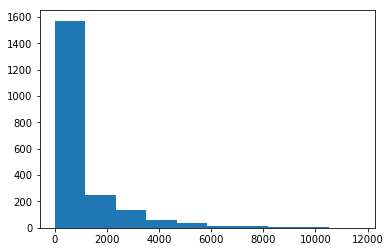

In [36]:
plt.hist(df_amelia.life_expectancy,bins =10)

## Split the predictor into multiple classes
* 3 classes 
* 12 classes

In [38]:
# Try with three classes first
labels = ["6months","1.2year","2years","3years","more"]
cut_points = [200,400,700,1100]

#labels = ["3_months","6_months","9_months","12_months","15_months","18_months","2_years","3_years","4_years","5_years","10_years","10_plus_years"]
#cut_points = [90,180,270,360,450,540,720,1095,1460,1825,3650]
df_amelia.loc[:,"life_expectancy_bin"] = binning(df_amelia.life_expectancy, cut_points, labels)
print(pd.value_counts(df_amelia.life_expectancy_bin, sort=False))

6months    300
1.2year    403
2years     520
3years     312
more       551
Name: life_expectancy_bin, dtype: int64


In [16]:
df_amelia.life_expectancy_bin.values

[1.2year, more, 1.2year, 1.2year, 3years, ..., 1.2year, 1.2year, 1.2year, more, 1.2year]
Length: 2086
Categories (3, object): [1.2year < 3years < more]

In [133]:
# In case you want something from seaborn
#sns.swarmplot(x="IK", y="Age_surgery", hue="life_expectancy_bin", data=df_amelia);

Below plot just shows relation between variables and predictor as pairplot (joint distribution)
Should be able to do this for everything
* Observe how for tumor grade 4 the blue part is highly likely - you'll leave less then 1.5 years unfortunately. 
* Looking at life expectancy and age surgery we see no obvious relationship, other than it's slightly to the left, so younger patients should live longer. 
* For IK it's the exact opposite, it seems that patients with IK will survive longer

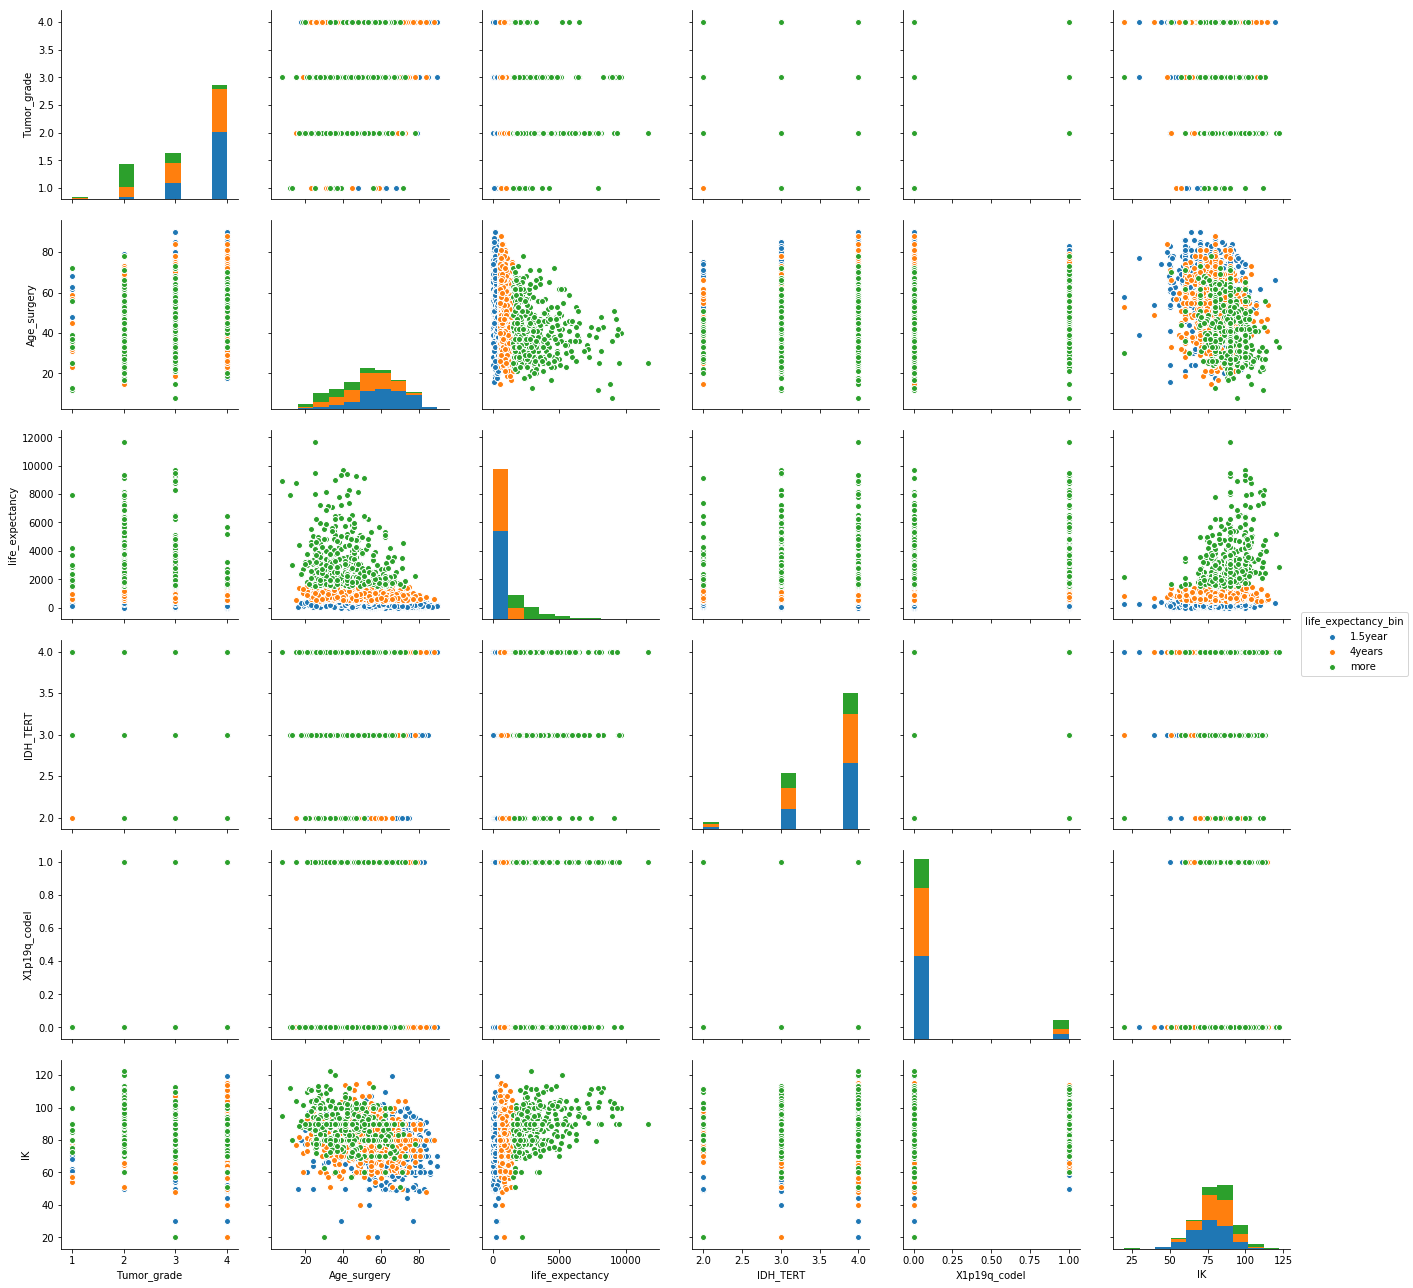

In [62]:
g = sns.pairplot(data=df_amelia,hue='life_expectancy_bin',size=3,kind='scatter')

In [17]:
for column in df_amelia:
    unique_vals = np.unique(df_amelia[column])
    nr_vals = len(unique_vals)
    if nr_vals < 20:
        print('Number of values for attribute {}: {} -- {}'.format(column, nr_vals, unique_vals))
    else:
        print('Number of values for attribute {}: {}'.format(column, nr_vals))

Number of values for attribute Gender: 2 -- ['F' 'M']
Number of values for attribute Tumor_type: 7 -- ['GBM' 'astrocytome' 'astrocytome gémistocytique (=A2)'
 'astrocytome pilocytique' 'gangliogliome' 'gliome' 'oligo']
Number of values for attribute Tumor_grade: 4 -- [1 2 3 4]
Number of values for attribute Gene_P53: 3 -- ['ALTERE' 'NC' 'NORMAL']
Number of values for attribute Gene_Mgmt: 2 -- ['METHYLE' 'NON METHYLE']
Number of values for attribute Gene_Egfr: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_Mdm2: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_Cdk4: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_P16: 2 -- ['DELETE' 'NORMAL']
Number of values for attribute Gene_Ihc_Atrx: 3 -- ['Extinction diffuse' 'Maintien' 'extinction']
Number of values for attribute Gene_Ch10Q: 2 -- ['NON PERTE' 'PERTE']
Number of values for attribute Gene_Ch9P: 3 -- ['GAIN' 'NON PERTE' 'PERTE']
Number of values for attribute Tumor_Location: 5 -- ['A' 'B' 

Create two encodings for the dataset: 
* Categorical, no order - only used for visualization purposes
* Dummies

Some questions:
* Should we standardize the continuous variables? 
* Label Encoder is used only for visualization purposes, we use One-hot-encoding (dummies) for our analysis

## Label Encoding

In [12]:
le_dict = dict() # Initialise an empty dictionary to keep all LabelEncoders
df_visualizer = df_amelia.copy(deep=True) 
# Loop over attributes by excluding the continuous oness
for column in df_visualizer.drop(['Age_surgery', 'life_expectancy', 'Tumor_grade','IDH_TERT','IK'], axis=1):  
    le = LabelEncoder().fit(df_visualizer[column]) # Initialise the LabelEncoder and fit
    df_visualizer[column] = le.transform(df_visualizer[column]) # Transform data and save in credit_clean DataFrame
    le_dict[column] = le # Store the LabelEncdoer in dictionary

In [95]:
# It doesn't really say much more than the previous one unfortunately
# g = sns.pairplot(data=df_visualizer,hue='life_expectancy_bin',size=3,kind='scatter')

## One Hot Encoding

In [18]:
df = df_amelia.copy(deep=True)
non_dummy_cols = ['Tumor_grade','IDH_TERT','life_expectancy','life_expectancy_bin','Gender','IK','Age_surgery']
dummy_cols = list(set(df.columns) - set(non_dummy_cols))

df = pd.get_dummies(df,columns=dummy_cols)

df.Gender.replace(to_replace={'M':1, 'F':0},inplace=True)
df.head(2)

,Gender,Tumor_grade,Age_surgery,life_expectancy,IDH_TERT,IK,life_expectancy_bin,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,X1p19q_codel_0,X1p19q_codel_1,TERT_mutant,TERT_wt,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,IDH_NC,IDH_mutant,IDH_wt,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE
0,1,3,42,30,3,90.512838,1.2year,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1
1,1,2,28,2069,2,90.596534,more,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,1,0


(array([1.572e+03, 2.490e+02, 1.330e+02, 5.900e+01, 3.500e+01, 1.500e+01,
        1.200e+01, 6.000e+00, 4.000e+00, 1.000e+00]),
 array([1.00000e+00, 1.16890e+03, 2.33680e+03, 3.50470e+03, 4.67260e+03,
        5.84050e+03, 7.00840e+03, 8.17630e+03, 9.34420e+03, 1.05121e+04,
        1.16800e+04]),
 <a list of 10 Patch objects>)

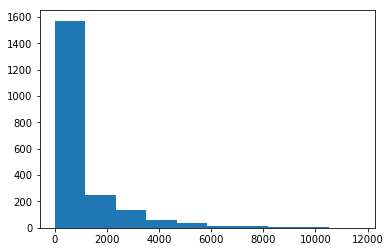

In [39]:
plt.hist(df_amelia.life_expectancy)

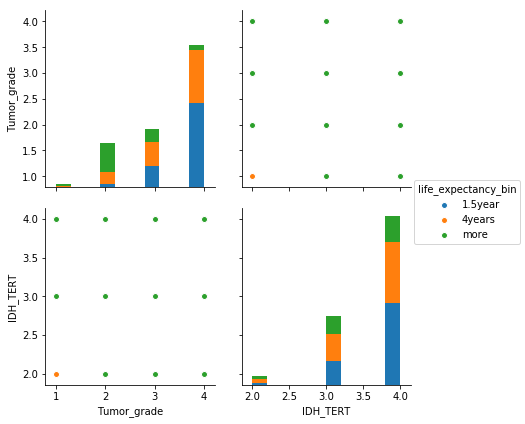

In [156]:
g = sns.pairplot(data=df,vars=['Tumor_grade','IDH_TERT'],hue='life_expectancy_bin',size=3)

In [157]:
df.columns

Index(['Gender', 'Tumor_grade', 'Age_surgery', 'life_expectancy', 'IDH_TERT',
       'IK', 'life_expectancy_bin', 'Gene_Mgmt_METHYLE',
       'Gene_Mgmt_NON METHYLE', 'Gene_Cdk4_AMPLIFIE', 'Gene_Cdk4_NORMAL',
       'Gene_Mdm2_AMPLIFIE', 'Gene_Mdm2_NORMAL', 'Gene_P53_ALTERE',
       'Gene_P53_NC', 'Gene_P53_NORMAL', 'Gene_Ch10Q_NON PERTE',
       'Gene_Ch10Q_PERTE', 'X1p19q_codel_0', 'X1p19q_codel_1',
       'Tumor_Position_D', 'Tumor_Position_G', 'Tumor_Position_bilatéral',
       'Tumor_Position_médian', 'Tumor_Position_non précisé',
       'Gene_P16_DELETE', 'Gene_P16_NORMAL', 'IDH_NC', 'IDH_mutant', 'IDH_wt',
       'Gene_Ihc_Atrx_Extinction diffuse', 'Gene_Ihc_Atrx_Maintien',
       'Gene_Ihc_Atrx_extinction', 'Gene_Ch9P_GAIN', 'Gene_Ch9P_NON PERTE',
       'Gene_Ch9P_PERTE', 'Gene_Egfr_AMPLIFIE', 'Gene_Egfr_NORMAL',
       'Surgery_type_aucune', 'Surgery_type_biopsie', 'Surgery_type_exérèse',
       'Surgery_type_partielle', 'TERT_mutant', 'TERT_wt', 'Tumor_type_GBM',
       'Tum

## Standardize continuous variables for non-trees methods
* Either fit on train and transform using test only or fit_transform the whole thing

In [65]:
#continuous_cols = ['Tumor_grade','IDH_TERT','IK','Age_surgery']
#sc = StandardScaler()
#df[continuous_cols] = sc.fit_transform(df[continuous_cols])

In [19]:
X = df.drop(["life_expectancy","life_expectancy_bin"], axis=1)
Y = df.life_expectancy_bin
#Y = LabelEncoder().fit_transform(df.life_expectancy_bin) 

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8, test_size=0.2, random_state=1332)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
X_train.head(2)

(1668, 54) (418, 54) (1668,) (418,)


,Gender,Tumor_grade,Age_surgery,IDH_TERT,IK,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,X1p19q_codel_0,X1p19q_codel_1,TERT_mutant,TERT_wt,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,IDH_NC,IDH_mutant,IDH_wt,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE
1650,1,4,61,3,68.175581,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1
397,1,3,34,3,70.000000,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,0


# NEXT STAGE
## At this stage we have the training and test data
When we do crossvalidation we'll have a different approach. Perform perhaps MCA
  * Random Forests - done below
  * Wide and Deep NN with Tensorflow - done in a separate notebook
  * K-Means style clustering

In [21]:
X_train.describe(include=[np.number])

,Gender,Tumor_grade,Age_surgery,IDH_TERT,IK,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Tumor_type_GBM,Tumor_type_astrocytome,Tumor_type_astrocytome gémistocytique (=A2),Tumor_type_astrocytome pilocytique,Tumor_type_gangliogliome,Tumor_type_gliome,Tumor_type_oligo,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,X1p19q_codel_0,X1p19q_codel_1,TERT_mutant,TERT_wt,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,IDH_NC,IDH_mutant,IDH_wt,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE
count,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000
mean,0.619904,3.386091,54.202038,3.651079,81.709285,0.489808,0.510192,0.302758,0.697242,0.583933,0.084532,0.006595,0.003597,0.007794,0.121103,0.192446,0.022782,0.363909,0.305156,0.308153,0.928058,0.014388,0.003597,0.050360,0.003597,0.902278,0.097722,0.666667,0.333333,0.436451,0.464029,0.047962,0.004197,0.047362,0.129496,0.870504,0.083933,0.762590,0.153477,0.082134,0.917866,0.005995,0.925060,0.068945,0.055156,0.479017,0.465827,0.214628,0.149880,0.635492,0.350719,0.649281,0.440048,0.559952
std,0.485556,0.809866,15.282010,0.547080,12.232744,0.500046,0.500046,0.459589,0.459589,0.493053,0.278268,0.080964,0.059886,0.087964,0.326345,0.394340,0.149252,0.481267,0.460612,0.461869,0.258470,0.119122,0.059886,0.218752,0.059886,0.297027,0.297027,0.471546,0.471546,0.496094,0.498854,0.213749,0.064665,0.212476,0.335849,0.335849,0.277370,0.425623,0.360555,0.274652,0.274652,0.077219,0.263374,0.253436,0.228353,0.499709,0.498980,0.410687,0.357061,0.481436,0.477338,0.477338,0.496542,0.496542
min,0.000000,1.000000,8.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,43.000000,3.000000,73.648527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.000000,55.000000,4.000000,80.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.00

## MODEL: Gradient Boosting and Random Forests
1. Gradient Boosting classifier
2. Random Forest classifier 
### Things to think about 
* Data standardization for the continuous variables - it's not necessary for trees. But otherwise sure why not. 
* Apply MCA to the categories - not so good according to plots from Alex
* Exploratory data analysis is what's missing here
* AUC seems wrong - double check
* Do Cross Validation with KFold
* Tune learning rate? Tune max_depth? Need some wisdom from somewhere on how to take it to the next step

In [22]:
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [24]:
# Gradient Boosting classifiers based on validation/test
estimators_range = [100, 200, 300, 400, 500, 1000, 2000]
accuracies = []
errors = []
roc_auc = []
cm = []
l = np.array(labels)

for n_estimators in estimators_range:
    gbc = GradientBoostingClassifier(learning_rate= 0.03, 
                                     n_estimators=n_estimators,
                                     max_depth =30,                          
                                     random_state = 1123)
    gbc.fit(X_train, Y_train)
    
    # Accuracy
    accuracies.append(gbc.score(X_test,Y_test)) 
    
    # XEntropy Error
    probas = gbc.predict_proba(X_test)
    y_pred = np.argmax(probas, axis=1)
    errors.append(log_loss(Y_test,probas))
    
    # ROC-AUC or Confusion matrix      
    cfm = confusion_matrix(Y_test, l[y_pred])
    cm.append(cfm)

#n_estimators_optimal_accuracies = estimators_range[np.argmax(accuracies)]
#n_estimators_optimal_errors = estimators_range[np.argmin(errors)]

In [33]:
# Random forests n_estimators based on validation set
estimators_range = [5, 10, 20, 50, 100, 200, 300, 400, 500]
accuracies = []
errors = []
roc_auc = []
cm = []
l = np.array(labels)
i=0
for n_estimators in estimators_range:
    rfc = RandomForestClassifier(criterion='entropy', 
                                   n_estimators=n_estimators,
                                   max_features = 30,
                                   max_depth =100,  
                                   n_jobs = -1,
                                   random_state = 1123)
    rfc.fit(X_train, Y_train)
    
    # Accuracy
    accuracies.append(rfc.score(X_test,Y_test)) 
    
    # XEntropy Error
    probas = rfc.predict_proba(X_test)
    y_pred = np.argmax(probas, axis=1)
    error = log_loss(Y_test,probas)
    errors.append(error)
    
    # Confusion matrix      
    cfm = confusion_matrix(Y_test, l[y_pred])
    cm.append(cfm)
    
    # ROC-AUC 
    Y_test_binary = label_binarize(Y_test, classes=labels)
    y_pred_binary = label_binarize(l[y_pred],classes =labels)
    auc_curve = multi_class_auc(len(l),Y_test_binary,y_pred_binary)
    roc_auc.append(auc_curve)
    i+=1
    print("Logloss {} --Random Forest Classifier with features = {}, max_depth = {}, estimators = {} -- {}/{}".format(error,rfc.max_features,rfc.max_depth,n_estimators,i,len(estimators_range)))


n_estimators_optimal_accuracies = estimators_range[np.argmax(accuracies)]
n_estimators_optimal_errors = estimators_range[np.argmin(errors)]

Logloss 4.037939927029055 --Random Forest Classifier with features = 30, max_depth = 100, estimators = 5 -- 1/9
Logloss 2.1951284746975697 --Random Forest Classifier with features = 30, max_depth = 100, estimators = 10 -- 2/9
Logloss 1.2507174704261743 --Random Forest Classifier with features = 30, max_depth = 100, estimators = 20 -- 3/9
Logloss 0.9994004618255986 --Random Forest Classifier with features = 30, max_depth = 100, estimators = 50 -- 4/9
Logloss 0.916642024547471 --Random Forest Classifier with features = 30, max_depth = 100, estimators = 100 -- 5/9
Logloss 0.8330904433371565 --Random Forest Classifier with features = 30, max_depth = 100, estimators = 200 -- 6/9
Logloss 0.8325467096687598 --Random Forest Classifier with features = 30, max_depth = 100, estimators = 300 -- 7/9
Logloss 0.8281454943356514 --Random Forest Classifier with features = 30, max_depth = 100, estimators = 400 -- 8/9
Logloss 0.8276984388445043 --Random Forest Classifier with features = 30, max_depth = 1

## EVALUATION: Confusion Matrix, ROC-AUC

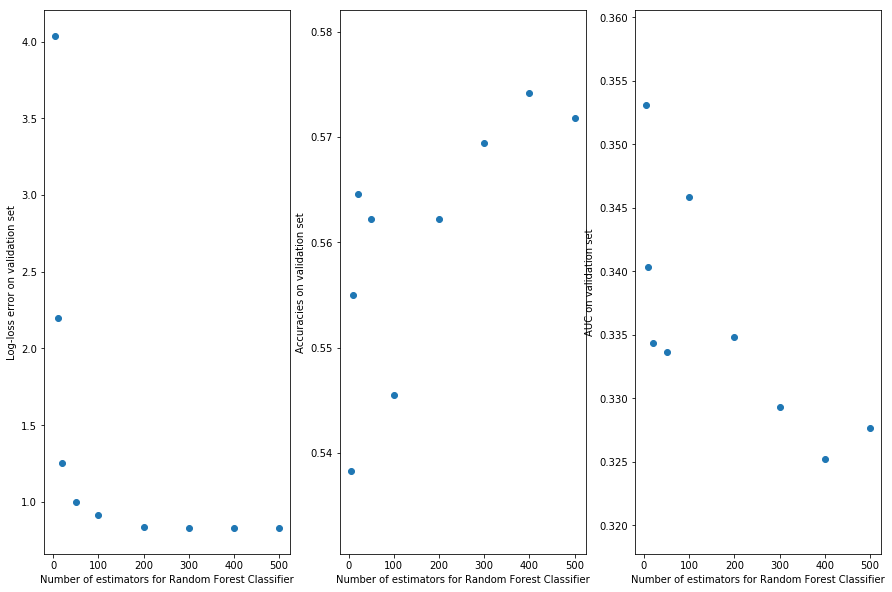

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(15,10))

ax[0].scatter(estimators_range, errors)
ax[0].set_ylabel('Log-loss error on validation set')
ax[0].set_xlabel('Number of estimators for Random Forest Classifier');

ax[1].scatter(estimators_range, accuracies)
ax[1].set_ylabel('Accuracies on validation set')
ax[1].set_xlabel('Number of estimators for Random Forest Classifier');

ax[2].scatter(estimators_range, roc_auc)
ax[2].set_ylabel('AUC on validation set')
ax[2].set_xlabel('Number of estimators for Random Forest Classifier');

#print('Optimal number of estimators based on validation set: {}\nLog-loss accuracy on validation set: {:.3f}'.
 #   format(n_estimators_optimal, validation_accuracy[np.argmin(validation_accuracy)]))   

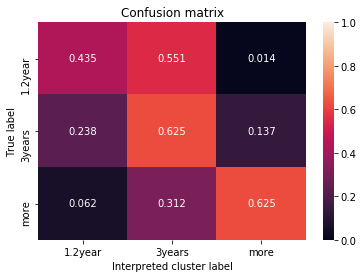

In [30]:
plt.figure()
plot_confusion_matrix(cm[5], norm=True, classes=labels)
plt.xlabel('Interpreted cluster label')
plt.show()

## Exporting data to a tree style graph for interpretation

In [116]:
dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names= df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
    class_names = labels,  
    filled=True, rounded=True,  
    special_characters=True)
graph = graphviz.Source(dot_data)
graph
#To create a file do this:
#To create a file do this:
with open("tree.dot", 'w') as f:
     f = export_graphviz(dt, out_file=f,
                         feature_names = df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
                         class_names = labels,   
                         filled=True, rounded=True,  
                         special_characters=True)